# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
# Download necessary NLTK data
import nltk
from jupyter_core.version import pattern

nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load data from csv and labeling the data
* csv file contains two columns: review and sentiment so we dont need to label the data

In [6]:
# Define the path to the manually downloaded dataset
data_path = "data/data.csv"  # Update the file name if it's different

# Check if the file exists before attempting to load
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset file not found at {data_path}. Ensure the file is in the correct location.")

# Load the dataset
df= pd.read_csv(data_path)
print("Dataset loaded successfully!")

# Display the first few rows of the DataFrame
df.head()


Dataset loaded successfully!


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## Perform Exploratory Data Analysis (EDA)


Class distribution:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Text length stats:
count    5842.000000
mean      117.022253
std        56.420425
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: text_length, dtype: float64


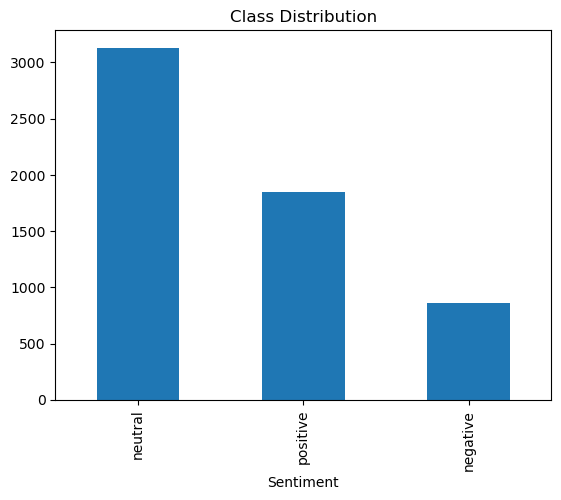

In [9]:
# Perform Exploratory Data Analysis (EDA)
def perform_eda(data):
    # Check class distribution
    print("Class distribution:")
    print(df['Sentiment'].value_counts())

    # Text length analysis
    df['text_length'] = df['Sentence'].apply(len)
    print("\nText length stats:")
    print(df['text_length'].describe())

    # Visualize class distribution
    df['Sentiment'].value_counts().plot(kind='bar', title="Class Distribution")
    plt.show()
perform_eda(df)

## Data review and cleaning
so taking a look to our data we can see there are a lot of words that are domain specific and not useful for our analysis so we should remove them <br>
There is also a noticeable class imbalance:
    * Positive reviews dominate, which could make a machine learning model biased toward predicting positive sentiments.
    * Techniques like oversampling (e.g., SMOTE), undersampling, or class-weight adjustments in algorithms can address this issue.
   *  Neutral reviews are the least represented class, which might challenge the model to differentiate between neutral and other sentiments.
<br>
So we begin with data cleaning and preprocessing to remove irrelevant information and standardize the text format. And then we begin handling domain specific words and sentiment specific words

In [17]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import html
import string

# Download necessary NLTK resources if not already done
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_and_lemmatize(text):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', 'url', text)

    # Decode HTML entities
    text = html.unescape(text)

    # Replace stock tickers with 'STOCK'
    text = re.sub(r'\$[A-Za-z]+', 'STOCK', text)

    # Handle cases with currencies like USD, EUR, GBP, etc.
    text = re.sub(r'(\b(?:USD|EUR|GBP|INR|JPY|CAD|AUD|CHF|CNY|ZAR|SEK|NOK|¥|€|₹|£))\s?(\d+(\,?\d{3})*(\.\d{1,2})?)', r'\1\2', text)

    # Remove space between digits and decimal points
    text = re.sub(r'(\d)\s?\.(\d)', r'\1.\2', text)  # For cases like 1 .6 -> 1.6

    # Remove space before or after a comma in large numbers like EUR1 ,000
    text = re.sub(r'(\d)\s?,(\d)', r'\1,\2', text)  # For cases like EUR1 ,000 -> EUR1,000

    # Ensure that numbers with units (e.g., EUR 1.6 m) have no spaces
    text = re.sub(r'(\d)\s?(billion|million|bn|mn|mln)', r'\1\2', text,flags=re.IGNORECASE)

    pattern = r"(?:(?:[\$\€\¥\£])\s?\d+(?:,\d{3})*(?:\.\d+)?(?:\s?(?:[kK]|[mM]illion|[bB]illion|[tT]housand|[mM][nNlL]?|[bB][nN]?)?)?)"
    text = re.sub(pattern, r"value ", text)  # Add a space after "money_value"

    pattern2 = r"(?:USD|EUR|GBP|JPY|AUD|CAD)\s?\d+(?:,\d{3})*(?:\.\d+)?(?:\s?(?:[kK]|[mM]illion|[bB]illion|[tT]housand|[mM][nNlL]?|[bB][nN]?)?)"
    text = re.sub(pattern2, r"value ", text)  # Add a space after "money_value"

    # Replace percentages
    text = re.sub(r'\d+(\.\d+)?\s?%|(\d+(\.\d+)?\s?percent)', 'percentage', text, flags=re.IGNORECASE)
    # Replace months, dates, years, and hours
    text = re.sub(r'\b(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\b', 'month', text)
    text = re.sub(r'\b\d{4}\b', 'year', text)
    text = re.sub(r'\b\d{1,2}(st|nd|rd|th)\b', 'date', text)
    text = re.sub(r'\b\d{1,2}[:]\d{2}\b', 'hour', text)

    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Tokenize and clean up text
    tokens = word_tokenize(text.lower())

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Use custom stopwords
    custom_stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in custom_stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into text
    return ' '.join(cleaned_tokens)

# Apply the cleaning function to the 'Sentence' column and create a new column 'cleaned_text'
df['cleaned_text'] = df['Sentence'].apply(clean_and_lemmatize)
df.head(100)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Sentence,Sentiment,text_length,cleaned_text
0,The GeoSolutions technology will leverage Bene...,positive,218,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,55,stock low value value k real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,193,last quarter year componenta net sale doubled ...
3,According to the Finnish-Russian Chamber of Co...,neutral,128,according finnishrussian chamber commerce majo...
4,The Swedish buyout firm has sold its remaining...,neutral,135,swedish buyout firm sold remaining percentage ...
...,...,...,...,...
95,M-Real said there are ` no grounds ' for the r...,neutral,117,mreal said ground rumor circulating market month
96,Lember said the matter was topical also in Est...,neutral,173,lember said matter topical also estonia bill d...
97,- Moody 's said it gave P A1 long-term senior ...,neutral,193,moody said gave p a1 longterm senior unsecured...
98,$TSLA recall,negative,12,stock recall


# Feature excraction with tf idf
now we will extract features with tf idf to get the most important words in the text

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Vectorize the cleaned text
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df['cleaned_text'])  # Feature matrix




# Splitting the data into training and testing sets

In [20]:
from sklearn.model_selection import train_test_split

# Assuming your 'sentiment' column contains labels like 'positive', 'negative', 'neutral'
y = df['Sentiment']  # Labels

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert sparse matrix to dense for SMOTE compatibility
X_train_dense = X_train.toarray()

# Apply SMOTE to oversample minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_dense, y_train)


# Training with logistic regression using cross validation


Cross-Validated Metrics (Resampled Data):
Accuracy: 0.8069
Precision: 0.8090
Recall: 0.8069
F1 Score: 0.8065


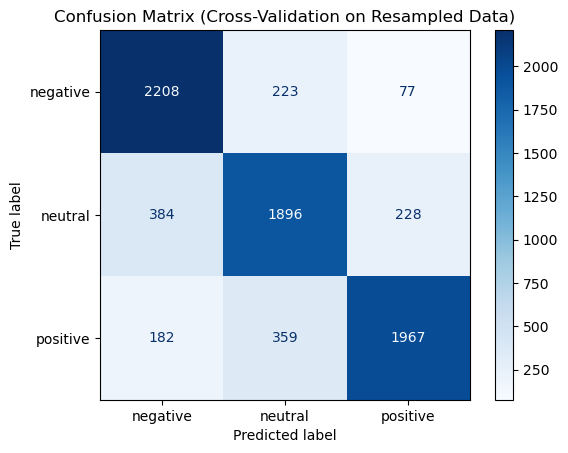


Simple Training Metrics (Resampled Data):
Accuracy: 0.8777
Precision: 0.8798
Recall: 0.8777
F1 Score: 0.8777


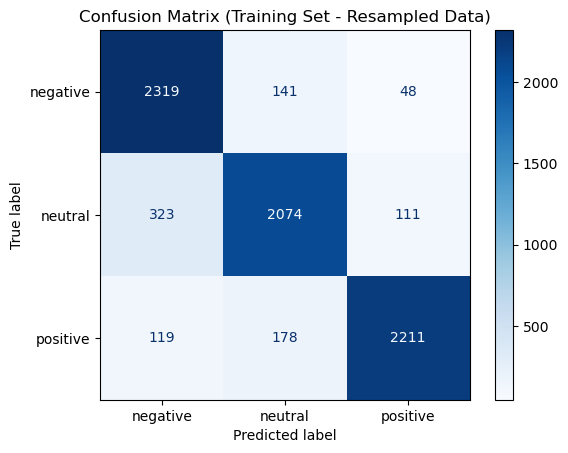

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
X_resampled = csr_matrix(X_resampled)

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')

# Cross-validation setup: use StratifiedKFold to maintain class balance in splits
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions using the resampled data
y_pred_cv = cross_val_predict(log_reg_model, X_resampled, y_resampled, cv=cv)

# Evaluate metrics using cross-validated predictions
accuracy = accuracy_score(y_resampled, y_pred_cv)
precision = precision_score(y_resampled, y_pred_cv, average='weighted')
recall = recall_score(y_resampled, y_pred_cv, average='weighted')
f1 = f1_score(y_resampled, y_pred_cv, average='weighted')

# Display cross-validation metrics
print(f"Cross-Validated Metrics (Resampled Data):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute and display the confusion matrix for cross-validation predictions
cm = confusion_matrix(y_resampled, y_pred_cv, labels=np.unique(y_resampled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_resampled))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Cross-Validation on Resampled Data)')
plt.show()

# Train the model on the full resampled training set
log_reg_model.fit(X_resampled, y_resampled)

# Predict the sentiment classes on the resampled training set (for evaluation)
y_pred_train = log_reg_model.predict(X_resampled)

# Compute and display metrics for simple training
train_accuracy = accuracy_score(y_resampled, y_pred_train)
train_precision = precision_score(y_resampled, y_pred_train, average='weighted')
train_recall = recall_score(y_resampled, y_pred_train, average='weighted')
train_f1 = f1_score(y_resampled, y_pred_train, average='weighted')

# Display simple training metrics
print("\nSimple Training Metrics (Resampled Data):")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Compute and display the confusion matrix for simple training predictions
cm_train = confusion_matrix(y_resampled, y_pred_train, labels=np.unique(y_resampled))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=np.unique(y_resampled))
disp_train.plot(cmap='Blues')
plt.title('Confusion Matrix (Training Set - Resampled Data)')
plt.show()


# Training with SVM using cross validation


Cross-Validated Metrics (Resampled Data):
Accuracy: 0.8368
Precision: 0.8460
Recall: 0.8368
F1 Score: 0.8386


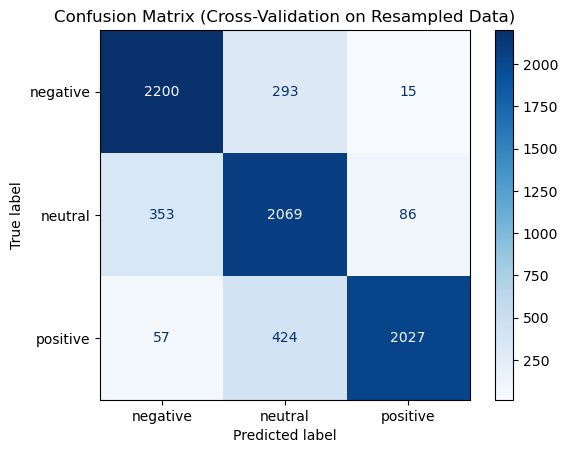


Test Set Metrics:
Accuracy: 0.9447
Precision: 0.9456
Recall: 0.9447
F1 Score: 0.9448


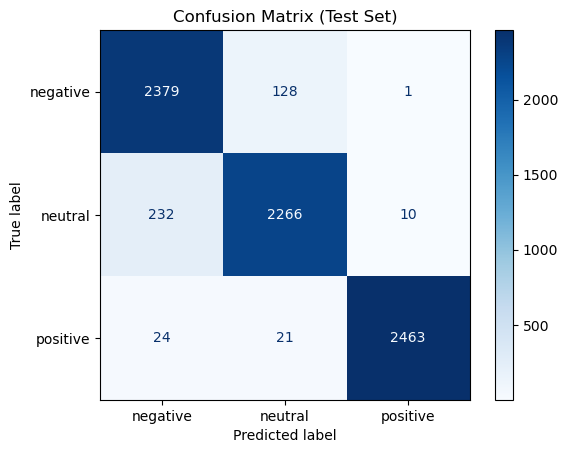

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt


# # Initialize the Support Vector Classifier (SVM) model
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovr')

# Cross-validation setup: use StratifiedKFold to maintain class balance in splits
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions using the resampled data
y_pred_cv = cross_val_predict(svm_model, X_resampled, y_resampled, cv=cv)

# Evaluate metrics using cross-validated predictions
accuracy = accuracy_score(y_resampled, y_pred_cv)
precision = precision_score(y_resampled, y_pred_cv, average='weighted')
recall = recall_score(y_resampled, y_pred_cv, average='weighted')
f1 = f1_score(y_resampled, y_pred_cv, average='weighted')

# Display cross-validation metrics
print("Cross-Validated Metrics (Resampled Data):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute and display the confusion matrix for cross-validation predictions
cm = confusion_matrix(y_resampled, y_pred_cv, labels=np.unique(y_resampled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_resampled))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Cross-Validation on Resampled Data)')
plt.show()

# Train the SVM model on the full resampled training set
svm_model.fit(X_resampled, y_resampled)

# Predict the sentiment classes on the test set
y_pred_test = svm_model.predict(X_resampled)

# Evaluate metrics for the test set
test_accuracy = accuracy_score(y_resampled, y_pred_test)
test_precision = precision_score(y_resampled, y_pred_test, average='weighted')
test_recall = recall_score(y_resampled, y_pred_test, average='weighted')
test_f1 = f1_score(y_resampled, y_pred_test, average='weighted')

# Display test set metrics
print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Compute and display the confusion matrix for test set predictions
cm_test = confusion_matrix(y_resampled, y_pred_test, labels=np.unique(y_resampled))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=np.unique(y_resampled))
disp_test.plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()
